## Part 1 Importing libraries and data

In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt 


website_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
retail_data = pd.read_excel(website_url) # This may take a couple minutes

In [2]:
retail_data = pd.read_excel (r'D:/Internship-2020/ROBOKEN-internship/Recommendation-system/Datset/Online Retail Original.xlsx')

## Part 2 Processing and cleaning of the data

In [3]:
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
cleaned_retail = retail_data.loc[pd.isnull(retail_data.CustomerID) == False]

In [6]:
cleaned_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [7]:
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) # Encode as strings for future lookup ease

In [8]:
item_lookup.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [9]:
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int) # Convert to int for customer ID
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']] # Get rid of unnecessary info
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index() # Group together
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
grouped_purchased = grouped_cleaned.query('Quantity > 0') # Only get customers where purchase totals were positive

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\test\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
grouped_purchased.head()

,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40


In [11]:
from pandas.api.types import CategoricalDtype
customers = list(np.sort(grouped_purchased.CustomerID.unique())) # Get our unique customers
products = list(grouped_purchased.StockCode.unique()) # Get our unique products that were purchased
quantity = list(grouped_purchased.Quantity) # All of our purchases

rows = grouped_purchased.CustomerID.astype(CategoricalDtype(categories = customers)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.StockCode.astype(CategoricalDtype(categories = products)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

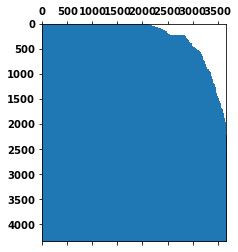

In [12]:
plt.spy(purchases_sparse)

In [13]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

4338
3664


In [14]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

98.32190920694744

## Part 3 Seperating testing and training data

In [15]:
import random

In [16]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered 

In [17]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

## Part 4: Implementing ALS for Implicit Feedback

In [18]:
def implicit_weighted_ALS(training_set, lambda_val = 0.1, alpha = 40, iterations = 10, rank_size = 20, seed = 0):
    '''
    Implicit weighted ALS taken from Hu, Koren, and Volinsky 2008. Designed for alternating least squares and implicit
    feedback based collaborative filtering. 
    
    parameters:
    
    training_set - Our matrix of ratings with shape m x n, where m is the number of users and n is the number of items.
    Should be a sparse csr matrix to save space. 
    
    lambda_val - Used for regularization during alternating least squares. Increasing this value may increase bias
    but decrease variance. Default is 0.1. 
    
    alpha - The parameter associated with the confidence matrix discussed in the paper, where Cui = 1 + alpha*Rui. 
    The paper found a default of 40 most effective. Decreasing this will decrease the variability in confidence between
    various ratings.
    
    iterations - The number of times to alternate between both user feature vector and item feature vector in
    alternating least squares. More iterations will allow better convergence at the cost of increased computation. 
    The authors found 10 iterations was sufficient, but more may be required to converge. 
    
    rank_size - The number of latent features in the user/item feature vectors. The paper recommends varying this 
    between 20-200. Increasing the number of features may overfit but could reduce bias. 
    
    seed - Set the seed for reproducible results
    
    returns:
    
    The feature vectors for users and items. The dot product of these feature vectors should give you the expected 
    "rating" at each point in your original matrix. 
    '''
    
    # first set up our confidence matrix
    
    conf = (alpha*training_set) # To allow the matrix to stay sparse, I will add one later when each row is taken 
                                # and converted to dense. 
    num_user = conf.shape[0]
    num_item = conf.shape[1] # Get the size of our original ratings matrix, m x n
    
    # initialize our X/Y feature vectors randomly with a set seed
    rstate = np.random.RandomState(seed)
    
    X = sparse.csr_matrix(rstate.normal(size = (num_user, rank_size))) # Random numbers in a m x rank shape
    Y = sparse.csr_matrix(rstate.normal(size = (num_item, rank_size))) # Normally this would be rank x n but we can 
                                                                 # transpose at the end. Makes calculation more simple.
    X_eye = sparse.eye(num_user)
    Y_eye = sparse.eye(num_item)
    lambda_eye = lambda_val * sparse.eye(rank_size) # Our regularization term lambda*I. 
    
    # We can compute this before iteration starts. 
    
    # Begin iterations
   
    for iter_step in range(iterations): # Iterate back and forth between solving X given fixed Y and vice versa
        # Compute yTy and xTx at beginning of each iteration to save computing time
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        # Being iteration to solve for X based on fixed Y
        for u in range(num_user):
            conf_samp = conf[u,:].toarray() # Grab user row from confidence matrix and convert to dense
            pref = conf_samp.copy() 
            pref[pref != 0] = 1 # Create binarized preference vector 
            CuI = sparse.diags(conf_samp, [0]) # Get Cu - I term, which is just CuI since we never added 1
            yTCuIY = Y.T.dot(CuI).dot(Y) # This is the yT(Cu-I)Y term 
            yTCupu = Y.T.dot(CuI + Y_eye).dot(pref.T) # This is the yTCuPu term, where we add the eye back in
                                                      # Cu - I + I = Cu
            X[u] = spsolve(yTy + yTCuIY + lambda_eye, yTCupu) 
            # Solve for Xu = ((yTy + yT(Cu-I)Y + lambda*I)^-1)yTCuPu, equation 4 from the paper  
        # Begin iteration to solve for Y based on fixed X 
        for i in range(num_item):
            conf_samp = conf[:,i].T.toarray() # transpose to get it in row format and convert to dense
            pref = conf_samp.copy()
            pref[pref != 0] = 1 # Create binarized preference vector
            CiI = sparse.diags(conf_samp, [0]) # Get Ci - I term, which is just CiI since we never added 1
            xTCiIX = X.T.dot(CiI).dot(X) # This is the xT(Cu-I)X term
            xTCiPi = X.T.dot(CiI + X_eye).dot(pref.T) # This is the xTCiPi term
            Y[i] = spsolve(xTx + xTCiIX + lambda_eye, xTCiPi)
            # Solve for Yi = ((xTx + xT(Cu-I)X) + lambda*I)^-1)xTCiPi, equation 5 from the paper
    # End iterations
    return X, Y.T # Transpose at the end to make up for not being transposed at the beginning. 
                         # Y needs to be rank x n. Keep these as separate matrices for scale reasons.

In [19]:
user_vecs, item_vecs = implicit_weighted_ALS(product_train, lambda_val = 0.1, alpha = 15, iterations = 1,
                                            rank_size = 20)

In [20]:
user_vecs[0,:].dot(item_vecs).toarray()[0,:5]

array([ 0.01218043, -0.00251753,  0.00943813,  0.00054114,  0.02303351])

### Better performing ALS update

In [21]:
import implicit

In [22]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

This method is deprecated. Please use the AlternatingLeastSquares class instead


## Part 5 Evaluation

In [23]:
from sklearn import metrics

In [24]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [25]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark


In [26]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)
# AUC for our recommender system


(0.871, 0.814)

## Part 6 Testing

In [27]:
customers_arr = np.array(customers) # Array of customer IDs from the ratings matrix
products_arr = np.array(products) # Array of product IDs from the ratings matrix

### Previous purchase of the customer

In [28]:
def get_items_purchased(customer_id, mf_train, customers_list, products_list, item_lookup):
    '''
    This just tells me which items have been already purchased by a specific user in the training set. 
    
    parameters: 
    
    customer_id - Input the customer's id number that you want to see prior purchases of at least once
    
    mf_train - The initial ratings training set used (without weights applied)
    
    customers_list - The array of customers used in the ratings matrix
    
    products_list - The array of products used in the ratings matrix
    
    item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available
    
    returns:
    
    A list of item IDs and item descriptions for a particular customer that were already purchased in the training set
    '''
    cust_ind = np.where(customers_list == customer_id)[0][0] # Returns the index row of our customer id
    purchased_ind = mf_train[cust_ind,:].nonzero()[1] # Get column indices of purchased items
    prod_codes = products_list[purchased_ind] # Get the stock codes for our purchased items
    return item_lookup.loc[item_lookup.StockCode.isin(prod_codes)]


In [29]:
customers_arr[:3]

array([12346, 12347, 12348], dtype=int64)

#### *Enter the customer id to get the list of products purchased*

In [30]:
get_items_purchased(12346, product_train, customers_arr, products_arr, item_lookup)

,StockCode,Description
61619,23166,MEDIUM CERAMIC TOP STORAGE JAR


### Suggesting Products to the customer

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    This function will return the top recommended items to our users 
    
    parameters:
    
    customer_id - Input the customer's id number that you want to get recommendations for
    
    mf_train - The training matrix you used for matrix factorization fitting
    
    user_vecs - the user vectors from your fitted matrix factorization
    
    item_vecs - the item vectors from your fitted matrix factorization
    
    customer_list - an array of the customer's ID numbers that make up the rows of your ratings matrix 
                    (in order of matrix)
    
    item_list - an array of the products that make up the columns of your ratings matrix
                    (in order of matrix)
    
    item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available
    
    num_items - The number of items you want to recommend in order of best recommendations. Default is 10. 
    
    returns:
    
    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    
    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order 
    # of best recommendations
    rec_list = [] # start empty list to store items
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]]) 
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions}) # Create a dataframe 
    return final_frame[['StockCode', 'Description']] # Switch order of columns around


#### *Enter the customer ID to get the list of products recommended* 

In [33]:
rec_items(12346, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,StockCode,Description
0,23167,SMALL CERAMIC TOP STORAGE JAR
1,23165,LARGE CERAMIC TOP STORAGE JAR
2,22980,PANTRY SCRUBBING BRUSH
3,22963,JAM JAR WITH GREEN LID
4,22979,PANTRY WASHING UP BRUSH
5,23294,SET OF 6 SNACK LOAF BAKING CASES
6,22978,PANTRY ROLLING PIN
7,23297,SET 40 HEART SHAPE PETIT FOUR CASES
8,22982,PANTRY PASTRY BRUSH
9,23295,SET OF 12 MINI LOAF BAKING CASES


### Some more examples

#### Example 1

In [34]:
get_items_purchased(12353, product_train, customers_arr, products_arr, item_lookup)

,StockCode,Description
2148,37446,MINI CAKE STAND WITH HANGING CAKES
2149,37449,CERAMIC CAKE STAND + HANGING CAKES
4859,37450,CERAMIC CAKE BOWL + HANGING CAKES
5108,22890,NOVELTY BISCUITS CAKE STAND 3 TIER


In [35]:
rec_items(12353, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,StockCode,Description
0,37447,CERAMIC CAKE DESIGN SPOTTED PLATE
1,22059,CERAMIC STRAWBERRY DESIGN MUG
2,37448,CERAMIC CAKE DESIGN SPOTTED MUG
3,22063,CERAMIC BOWL WITH STRAWBERRY DESIGN
4,22055,MINI CAKE STAND HANGING STRAWBERY
5,22057,CERAMIC PLATE STRAWBERRY DESIGN
6,22649,STRAWBERRY FAIRY CAKE TEAPOT
7,22645,CERAMIC HEART FAIRY CAKE MONEY BANK
8,72351B,SET/6 PINK BUTTERFLY T-LIGHTS
9,22644,CERAMIC CHERRY CAKE MONEY BANK


#### Example 2

In [36]:
get_items_purchased(12361, product_train, customers_arr, products_arr, item_lookup)

,StockCode,Description
34,22326,ROUND SNACK BOXES SET OF4 WOODLAND
35,22629,SPACEBOY LUNCH BOX
37,22631,CIRCUS PARADE LUNCH BOX
93,20725,LUNCH BAG RED RETROSPOT
369,22382,LUNCH BAG SPACEBOY DESIGN
547,22328,ROUND SNACK BOXES SET OF 4 FRUITS
549,22630,DOLLY GIRL LUNCH BOX
1241,22555,PLASTERS IN TIN STRONGMAN
58132,20725,LUNCH BAG RED SPOTTY


In [37]:
rec_items(12361, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,StockCode,Description
0,22662,LUNCH BAG DOLLY GIRL DESIGN
1,20726,LUNCH BAG WOODLAND
2,20724,RED RETROSPOT CHARLOTTE BAG
3,20728,LUNCH BAG CARS BLUE
4,23206,LUNCH BAG APPLE DESIGN
5,20727,LUNCH BAG BLACK SKULL.
6,22383,LUNCH BAG SUKI DESIGN
7,20712,JUMBO BAG WOODLAND ANIMALS
8,20719,WOODLAND CHARLOTTE BAG
9,23199,JUMBO BAG APPLES


##  Part 7 Final output

Enter the customer ID to get the list of recommendation

In [38]:
Customer_id = int(input('The ID of the customer is: '))
Reco_number = int(input('Number of recommendations: '))

The ID of the customer is: 12347
Number of recommendations: 12


### List of item purchased vs suggested

In [47]:
print('Following is the list of items purchased by Customer no.', Customer_id)
get_items_purchased(Customer_id, product_train, customers_arr, products_arr, item_lookup)

Following is the list of items purchased by Customer no. 12347


,StockCode,Description
26,22728,ALARM CLOCK BAKELIKE PINK
27,22727,ALARM CLOCK BAKELIKE RED
28,22726,ALARM CLOCK BAKELIKE GREEN
32,21791,VINTAGE HEADS AND TAILS CARD GAME
33,21035,SET/2 RED RETROSPOT TEA TOWELS
...,...,...
409231,23480,MINI LIGHTS WOODLAND MUSHROOMS
424558,23497,CLASSIC CHROME BICYCLE BELL
451781,23497,CLASSIC CROME BICYCLE BELL
467349,71477,COLOURED GLASS STAR T-LIGHT HOLDER


In [48]:
print('Following is the list of items recommended to Customer no.', Customer_id)
rec_items(Customer_id, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = Reco_number)

Following is the list of items recommended to Customer no. 12347


,StockCode,Description
0,21787,RAIN PONCHO RETROSPOT
1,15056BL,EDWARDIAN PARASOL BLACK
2,22616,PACK OF 12 LONDON TISSUES
3,21786,POLKADOT RAIN HAT
4,15056N,EDWARDIAN PARASOL NATURAL
5,20679,EDWARDIAN PARASOL RED
6,15056P,EDWARDIAN PARASOL PINK
7,85014B,RED RETROSPOT UMBRELLA
8,23123,COCKTAIL SWORDS 50 PIECES
9,21934,SKULL SHOULDER BAG
